# **Importing Libraries & Data**

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
# importing the csv file
data = pd.read_csv('online_retail_one_year.csv')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# **Data Quality Checks**

In [150]:
# Check size of dataset
data.shape

(1067371, 8)

In [151]:
# Check for missing values
data.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [152]:
# Understanding the data types of all columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [153]:
# Check for duplicate records
data.duplicated().sum()

np.int64(34335)

# **Data Cleaning**

In [154]:
# Delete rows with missing Customer ID
data.dropna(subset=['Customer ID'], inplace=True)

In [155]:
# Rename Customer ID column to CustomerID
data.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)

In [156]:
# Convert the datatype of InvoiceDate to DateTime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Convert the dataype of Customer ID to int
data['CustomerID'] = data['CustomerID'].astype(int)

In [157]:
# Drop all duplicate records
data.drop_duplicates(inplace=True)

In [158]:
# Remove cancelled and returned orders
data = data[~data['Invoice'].str.contains('C')]

# Remove Items with negative prices and quantity
data = data[data['Quantity'] > 0]
data = data[data['Price'] > 0]

In [159]:
# Create new column, Revenue = Quantity * Price
data['Revenue'] = data['Quantity'] * data['Price']

# **Feature Engineering**

In [160]:
# Construct new features Order Date & Order Month
data['OrderDate'] = data['InvoiceDate'].dt.date
data['OrderMonth'] = data['InvoiceDate'].dt.month

In [161]:
# first purchase per customer
first_purchase = data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']

data = data.merge(first_purchase, on='CustomerID', how='left')

In [162]:
# Cohort month
data['CohortMonth'] = data['FirstPurchaseDate'].dt.to_period('M')

In [163]:
# New v/s. Repeat Customer Flag
data['RepeatCustomer'] = data.groupby('CustomerID')['Invoice'].transform('nunique') > 1

In [164]:
# Basket Level Revenue
data['BasketLevelRevenue'] = data.groupby(['Invoice', 'CustomerID'])['Revenue'].transform('sum')

# **Exploratory Data Analysis (EDA)**

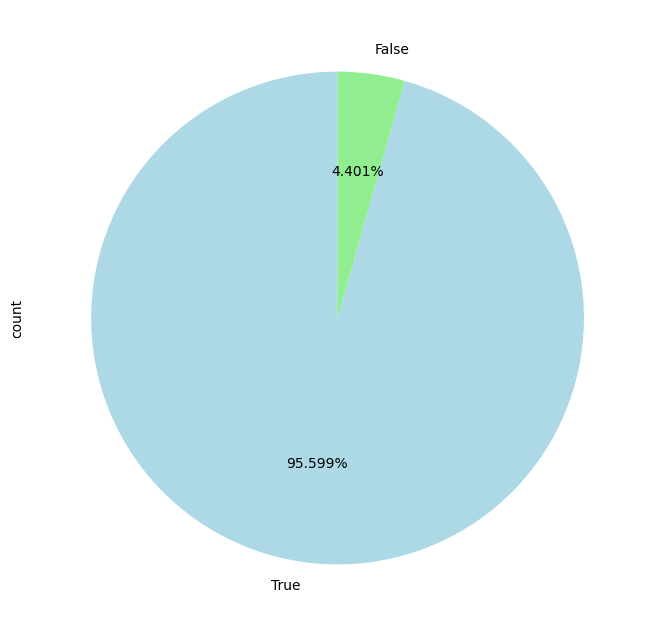

In [165]:
# Pie Chart of Repeat v/s. One Time Customer
plt.figure(figsize=(8, 8))
data['RepeatCustomer'].value_counts().plot(kind='pie', autopct='%1.3f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.show()

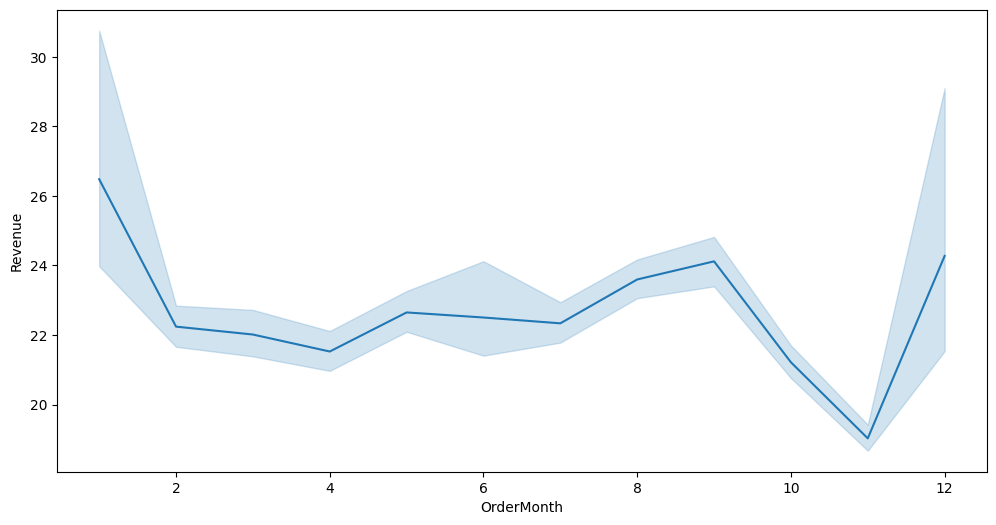

In [166]:
# Plot Monthly Revenue
plt.figure(figsize=(12, 6))
sns.lineplot(x='OrderMonth', y='Revenue', data=data)
plt.show()

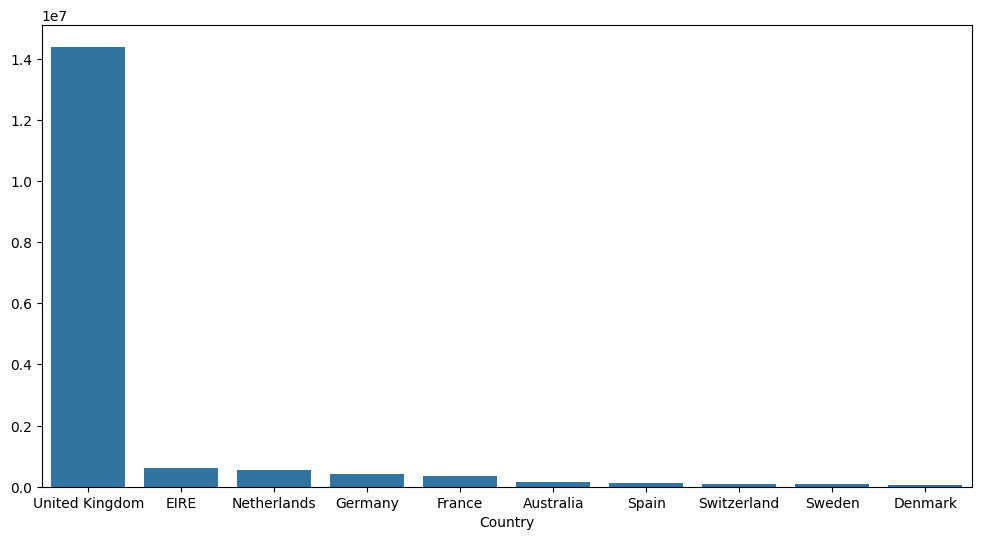

In [167]:
# Top country by revenue v/s. total transactions
top_countries = data.groupby('Country')['Revenue'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.show()


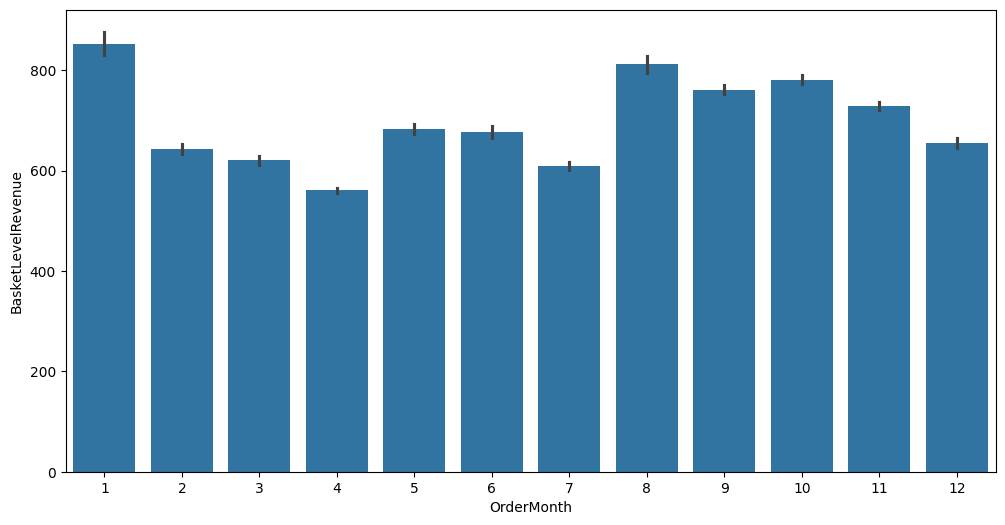

In [168]:
# Average Order Value V/.s Month
plt.figure(figsize=(12, 6))
sns.barplot(x='OrderMonth', y='BasketLevelRevenue', data=data)
plt.show()

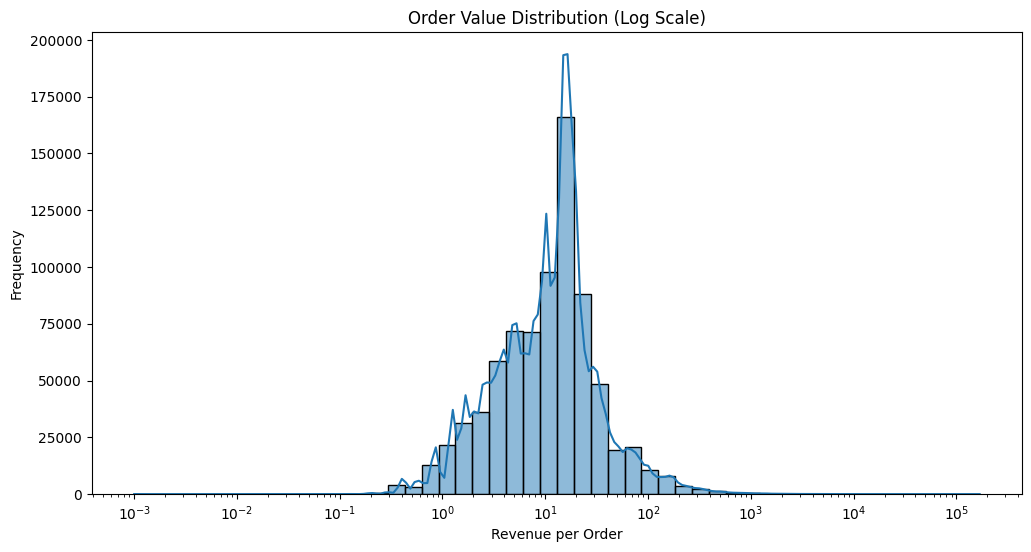

In [169]:
# Histogram of Order Value Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data['Revenue'], bins=50, kde=True, log_scale=True)
plt.title("Order Value Distribution (Log Scale)")
plt.xlabel("Revenue per Order")
plt.ylabel("Frequency")
plt.show()

### **Overall Business Takeaways**

* **Loyalty is key**: Repeat customers dominate purchases. Focus on retention strategies.

* **Seasonality matters:** Revenue and basket size fluctuate across the year; marketing and inventory planning should align.

* **Market concentration:** UK drives majority revenue but still potential to grow in other countries.

* **Revenue optimization:** Small-to-medium orders dominate; opportunity to increase AOV via bundles, discounts, or targeted promotions.

# **Funnel Analysis**

## **Funnel 1: Repeat Purchase Funnel**
All Customers → Repeat Customers

In [170]:
total_customers = data['CustomerID'].nunique()
repeat_customers = (
    data[data['RepeatCustomer'] == True]['CustomerID']
    .nunique()
)

In [171]:
funnel_repeat = pd.DataFrame({
    "Stage": ["All Customers", "Repeat Customers"],
    "Users": [total_customers, repeat_customers]
})

funnel_repeat["ConversionRate"] = (
    funnel_repeat["Users"] / funnel_repeat["Users"].shift(1) * 100
)

In [172]:
funnel_repeat["DropoffRate"] = 100 - funnel_repeat["ConversionRate"]
funnel_repeat

,Stage,Users,ConversionRate,DropoffRate
0,All Customers,5878,NaN,NaN
1,Repeat Customers,4255,72.388568,27.611432


/tmp/ipython-input-2522204796.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stage', y='Users', data=funnel_repeat, palette='Blues_d')


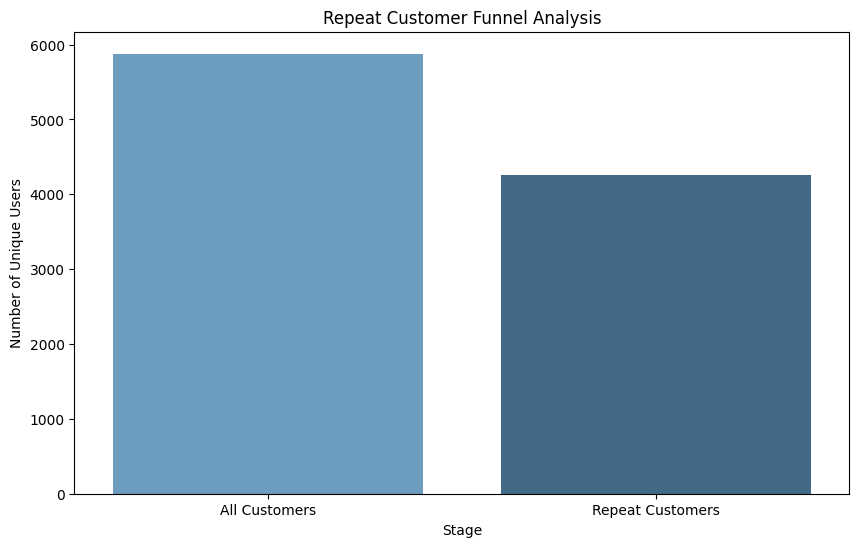

In [173]:
# Funnel Visualization
plt.figure(figsize=(10,6))
sns.barplot(x='Stage', y='Users', data=funnel_repeat, palette='Blues_d')
plt.title('Repeat Customer Funnel Analysis')
plt.ylabel('Number of Unique Users')
plt.show()

### **Funnel 1: Repeat Purchase Funnel**

***(All Customers → Repeat Customers)***

**Key Results**
* Total Customers: 5,878
* Repeat Customers: 4,255
* Conversion to Repeat Purchase: 72.4%
* Drop-off after First Purchase: 27.6%


---



**Conclusion:**

A strong majority of customers return for at least one additional purchase, indicating healthy baseline retention in the business. However, over a quarter of customers churn after their first transaction, highlighting an opportunity to improve early-stage engagement and post-purchase experience to convert more first-time buyers into repeat customers.

---

**Business Implication:**

Improving onboarding, follow-up communication, and first-purchase incentives could significantly reduce early churn and increase lifetime value without requiring additional customer acquisition spend.

## **Funnel 2: Invoice / Order-Level Funnel**
Customers → Orders (Invoices) → Items → Revenue

In [174]:
customers = data['CustomerID'].nunique()
orders = data['Invoice'].nunique()
items = len(data)
revenue = data['Revenue'].sum()

In [175]:
funnel_invoice = pd.DataFrame({
    "Stage": ["Customers", "Orders", "ItemsSold", "TotalRevenue"],
    "Value": [customers, orders, items, revenue]
})

funnel_invoice


,Stage,Value
0,Customers,5.878000e+03
1,Orders,3.696900e+04
2,ItemsSold,7.794250e+05
3,TotalRevenue,1.737480e+07


### **Funnel 2: Invoice / Order-Level Value Funnel**

***(Customers → Orders → Items Sold → Total Revenue)***


**Key Results:**
* Customers: 5,878
* Orders: 36,969
* Items Sold: 779,425
* Total Revenue: 17.37M

---

**Conclusion:**

The value funnel shows that a relatively moderate customer base generates a disproportionately high number of orders and items sold, resulting in strong overall revenue. This indicates that revenue growth is driven more by repeat ordering behavior and basket expansion than by sheer customer acquisition volume.

---

**Business Implication:**

Strategies focused on increasing order frequency and basket size, such as cross-selling, bundling, and personalized product recommendations, are likely to yield higher revenue impact than acquisition-led growth alone.

## **Funnel 3: Cohort Retention Funnel**
Cohort Month 0 → Month 1 → Month 2 → Month 3 → ...

In [177]:
data['OrderMonth'] = pd.to_datetime(data['OrderDate']).dt.to_period('M')

In [178]:
data['CohortIndex'] = (
    data['OrderMonth'] - data['CohortMonth']
).apply(lambda x: x.n)


In [179]:
cohort_counts = (
    data
    .groupby(['CohortMonth', 'CohortIndex'])['CustomerID']
    .nunique()
    .reset_index()
)

In [180]:
cohort_pivot = cohort_counts.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)

In [181]:
retention = cohort_pivot.divide(cohort_pivot[0], axis=0)
retention_percent = (retention * 100).round(1)
retention_percent


CohortIndex,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,100.0,35.3,33.4,42.5,38.0,35.9,37.7,34.2,33.6,36.2,...,30.3,26.3,30.3,28.3,26.0,25.5,31.5,30.5,40.7,19.7
2010-01,100.0,20.6,31.1,30.5,26.4,30.0,25.8,23.0,27.9,31.9,...,15.1,23.5,19.8,18.5,19.6,24.3,19.3,24.5,5.7,NaN
2010-02,100.0,23.8,22.5,29.1,24.6,20.1,19.3,28.6,25.4,27.5,...,20.1,16.0,16.3,14.4,23.0,23.0,16.3,5.9,NaN,NaN
2010-03,100.0,19.0,23.0,24.2,23.3,20.3,24.6,30.2,27.5,10.8,...,16.9,17.4,15.6,17.6,20.1,21.2,7.9,NaN,NaN,NaN
2010-04,100.0,19.4,19.4,16.3,18.4,22.4,27.6,26.2,10.5,10.9,...,15.6,13.9,15.0,18.0,22.4,5.8,NaN,NaN,NaN,NaN
2010-05,100.0,15.7,16.9,17.3,17.7,25.6,21.3,12.6,5.9,8.3,...,12.6,13.8,16.5,15.4,4.7,NaN,NaN,NaN,NaN,NaN
2010-06,100.0,17.4,18.9,20.4,23.0,28.5,12.6,8.9,8.1,11.9,...,12.2,13.3,20.4,5.2,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,100.0,15.6,18.3,29.6,29.0,14.0,11.3,14.5,14.5,11.3,...,17.2,23.7,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,100.0,20.4,29.6,32.1,17.3,11.7,9.9,12.3,13.6,13.0,...,19.8,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Funnel 3: Cohort Retention Funnel**

***(Month 0 → Month 1 → Month 2 → …)***

**Key Observations:**
* All cohorts start at 100% in Month 0, confirming correct cohort construction.
* A sharp drop-off occurs between Month 0 and Month 1, with most cohorts retaining only 15–35% of customers after the first month.
* After the initial decline, retention stabilizes across later months, indicating the presence of a smaller but consistent group of loyal customers.
* Earlier cohorts show longer retention tails, while more recent cohorts have fewer observed months due to data availability, which explains the presence of missing values.

**Conclusion:**
The cohort retention funnel reveals that the primary customer loss happens immediately after the first purchase. However, customers who return beyond the first month tend to exhibit relatively stable repeat behavior over time. This suggests that early engagement is the critical determinant of long-term retention, and that once customers cross the initial repeat threshold, they are more likely to remain active.

**Business Implication:**

Improving first-to-second purchase conversion through targeted onboarding, post-purchase communication, and time-bound incentives could significantly increase overall customer lifetime value. Retention efforts should be concentrated in the first month, where the largest drop-off is observed.